In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from mice_dfi import plots

## Load data

In [2]:
df_validation = pd.read_csv('./generated/validation_data.csv')

## Fit data and plot

In [3]:
fileformat = 'svg'
os.makedirs('./figs',exist_ok=True)  # saving pngs
os.makedirs('./source',exist_ok=True)  # saving source data
bbox_inches = None # None  or 'tight'
production = True
plots.set_style(production=production)
cm = 1/2.54  # centimeters in inches
dpi=300
if production:
    fig_size = 8.8 * cm
    fontsize = 7
    scale=0.5
else:
    fig_size = 18. * cm
    fontsize = 16
    scale= 1
    fileformat = 'png'

In [4]:
def round_age(x, base=10.):
    return (np.round(x / base) + 0.5)*base

def jacobian_exp_fit(x, a, b, c):
    return np.asarray([np.exp(b*x), a*x*np.exp(b*x), np.ones_like(x)]).T

def exp_fit(x, a, b, c):
    return a*np.exp(b*x) + c


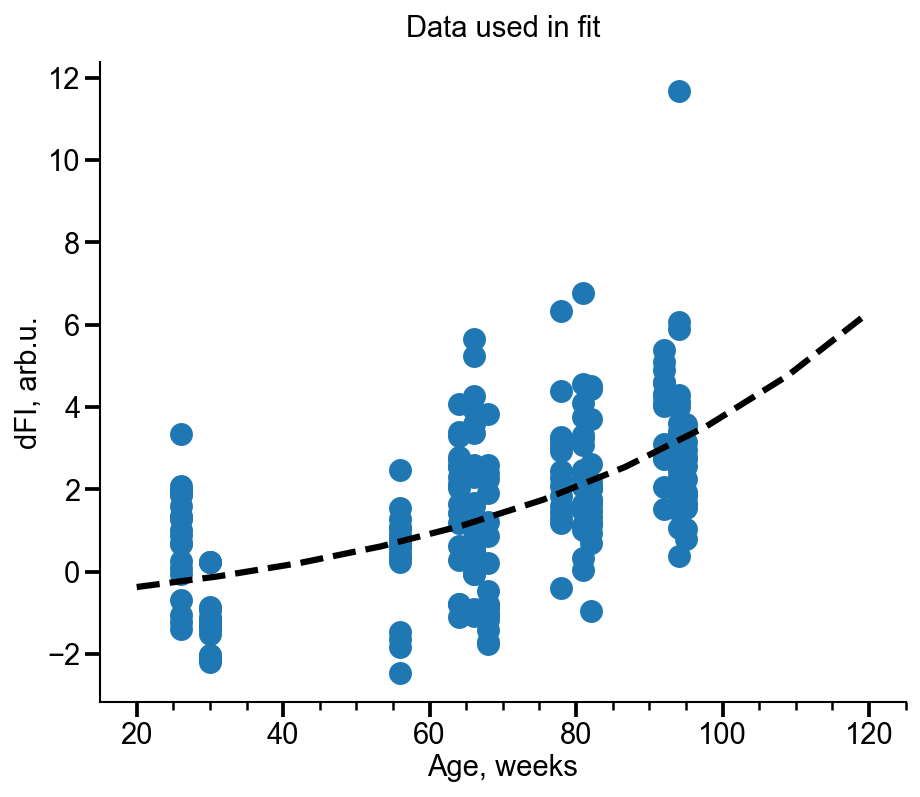

[ 0.6938392   0.02006599 -1.40650075] [-8.64000039e-01  1.28997739e-03 -3.87415366e+00] [2.25167844 0.03884199 1.06115217]


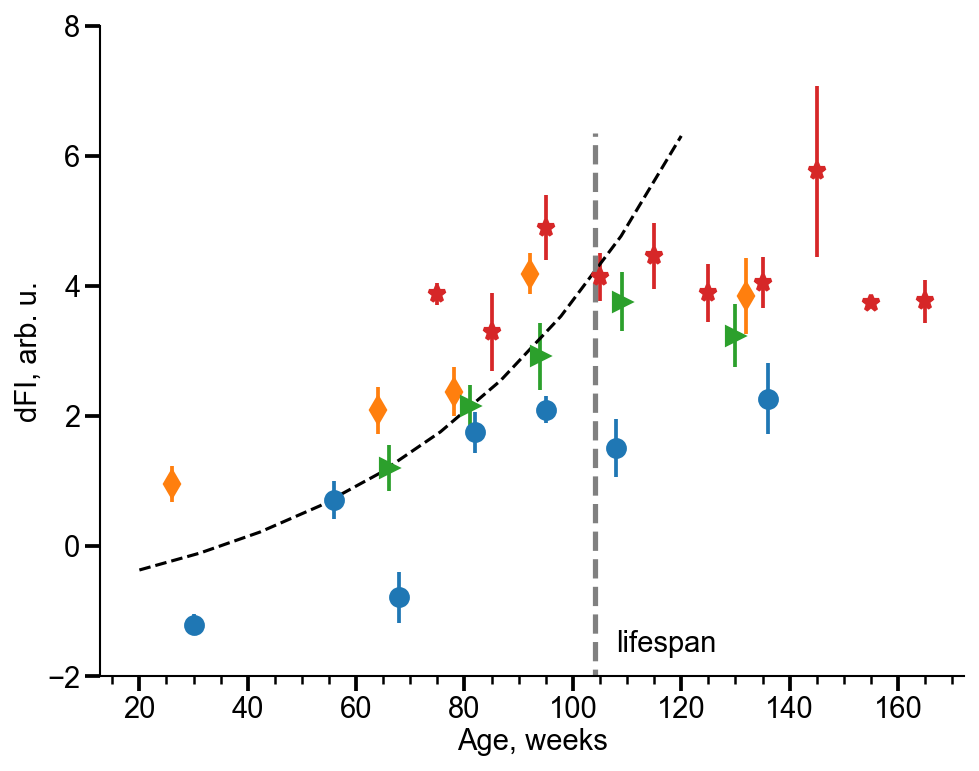

In [5]:
figsize=(fig_size, fig_size*0.8)
# figsize=(4.167, 3.490)
figname = 'fig3_dfi_age'

# Fit exponetial curve 
df = df_validation.dropna(subset=['dFI'])
data = df[['age', 'dFI', 'label']].values
x, y, labl = data[:, 0], data[:, 1], data[:, 2]
x = x.astype(float)
y = y.astype(float)
fit_age_mask = x < 104  # fit before lifespan ends
fit_age_mask *= np.isin(labl, ['MA0071_F', 'MA0071_M', 'MA0072_M']) 


popt_exp, perr_exp = scipy.optimize.curve_fit(exp_fit, x[fit_age_mask], y[fit_age_mask], p0=[0.001, 0.3, 0.], maxfev=2000, jac=jacobian_exp_fit)
err = np.sqrt(np.diag(np.abs(perr_exp)))
xlin = np.linspace(20, 120, 10)

plt.figure(figsize=figsize, dpi=300)
plt.scatter(x[fit_age_mask], y[fit_age_mask])
plt.plot(xlin, exp_fit(xlin, *popt_exp),  '--', c='k', lw=1.5, label="$z=%.2f \cdot e^{(%.3f \cdot  t)}%.1f $ " % (popt_exp[0], popt_exp[1], popt_exp[2]))
plt.xlabel('Age, weeks')
plt.ylabel('dFI, arb.u.')
plt.title('Data used in fit')
plt.show()


# Fig3
print( popt_exp, popt_exp - 2.*err, popt_exp + 2.*err)
markers = ['o', 'd', '>', '*', '^']
fig = plt.figure(figsize=figsize, dpi=300)

source = {}
for ii, (i, df_) in enumerate(df.groupby(['label'])):
    l = i.split('_')[0]
    try:
        l += ', (m)' if  i.split('_')[1] == 'M' else ', (f)'
    except IndexError:
        l += ', (m)'
    if i == 'MA0073':
        df_ = df_.copy()
        df_['age'] = df_['age'].apply(round_age)
        data = df_.groupby('age', as_index=False).median()[['age', 'dFI']].values
        err_sem =  df_.groupby('age').sem()['dFI'].values
    else:
        data = df_.groupby('age', as_index=False).median()[['age', 'dFI']].values
        err_sem =  df_.groupby('age').sem()['dFI'].values
    x, y = data[:, 0], data[:, 1]
    plt.errorbar(x, y, yerr=err_sem,  fmt=markers[ii], ms=8*scale)
    source[i] = {}
    source[i]['x'] = x
    source[i]['y'] = y
    source[i]['yerr'] = err_sem

# Plot lifespan threshold
min_val, max_val = df_validation.loc[:, 'dFI'].min(), np.percentile(df_validation.loc[:, 'dFI'].dropna(), 95)
diff = max_val - min_val
plt.plot(xlin, exp_fit(xlin,*popt_exp),  '--', c='k', lw=1.5*scale, label="$z=%.2f \cdot e^{(%.3f \cdot  t)}%.1f $ " % (popt_exp[0], popt_exp[1], popt_exp[2]))
plt.plot([104, 104], [min_val, max_val-diff*0.1],  '--', c='grey', lw=2.5*scale)
plt.annotate(text='lifespan', xy=(104, 1), xytext=(108, min_val+diff*0.1), fontsize=fontsize)

# add legend and axis labels
# plt.legend(fontsize=fontsize, loc=2)
plt.xlabel('Age, weeks')
plt.ylabel('dFI, arb. u.')
plt.ylim(-2, 8)

# Save figure and source
fig.tight_layout()
fig.savefig('./figs/{:s}.{:s}'.format(figname, fileformat), bbox_inches=bbox_inches, dpi=300)
plt.show()

# Save data source for NC submission
for tag, data in source.items():
    df = pd.DataFrame(data)
    try:
        with pd.ExcelWriter('./source/{:s}.xlsx'.format(figname), engine="openpyxl",  mode="a", if_sheet_exists="replace") as writer:
            df.to_excel(writer, sheet_name=tag)
    except FileNotFoundError:
        with pd.ExcelWriter('./source/{:s}.xlsx'.format(figname), engine="openpyxl") as writer:
            df.to_excel(writer, sheet_name=tag)
